In [1]:
import numpy as np
import pandas as pd

from filing import Filing

In [10]:
class SeasonData:
    def __init__(self, year=2022, **kwargs):
        self.season = f'{year}-{year+1}'
        self.filing = Filing(self.season)

        self.site = kwargs.get('site', 'draftkings')
    
    def load(self, **kwargs):

        if hasattr(self, 'clean'):
            return self.clean
        
        raw = self.filing.load_boxscores()

        columns = [
            'date',
            'name',
            'starter',
            'team',
            'opp',

            'mp',
            'fpts', # **
            'fppm',
            
            'pts',
            'ast',
            'trb',
            'stl',
            'blk',
            'tov',
            
            'usg',
            'ts',
            'ast_pct', 

            'spread',
            'total'
        ]

        self.clean = (raw
                      .assign(
                          fpts=lambda df_: df_.dk_fpts if self.site == 'draftkings' else df_.fd_fpts,
                          fppm=lambda df_: df_.fpts / df_.mp,
                          **{c: lambda df_, c=c:df_[c].astype('uint8') for c in ('pts', 'ast', 'trb', 'stl', 'blk', 'tov')}
                      )
                      .round(3)
                      [columns]
                     )
        
        return self.clean

In [11]:
season = SeasonData()

In [12]:
df = season.load()

In [13]:
df.sample(5)

,date,name,starter,team,opp,mp,fpts,fppm,pts,ast,trb,stl,blk,tov,usg,ts,ast_pct,spread,total
8,2022-11-11,Trey Lyles,0,SAC,LAL,14.500,4.00,0.276,0,1,2,0,0,0,11.9,0.000,7.4,6,234
3,2022-11-30,Dennis Schröder,1,LAL,POR,29.083,13.75,0.473,6,5,1,0,0,2,13.5,0.403,19.2,19,237
7,2022-12-15,Devonte' Graham,0,NO,UTA,20.017,15.75,0.787,8,3,3,0,0,2,18.2,0.592,19.0,-3,261
0,2022-10-25,Ivica Zubac,1,LAC,OKC,34.700,44.00,1.268,10,2,14,0,7,1,12.7,0.556,9.9,-14,202
0,2022-10-24,Anfernee Simons,1,POR,DEN,35.583,47.25,1.328,29,5,3,1,1,1,23.2,0.853,20.3,25,245
10,2022-12-04,Jack White,0,DEN,NO,2.050,3.25,1.585,2,0,1,0,0,0,0.0,0.000,0.0,-15,227
9,2022-11-20,Wenyen Gabriel,0,LAL,SA,16.083,9.75,0.606,2,1,5,0,0,0,2.7,1.000,7.1,31,215
9,2022-11-19,Trendon Watford,0,POR,UTA,4.517,0.00,0.000,0,0,0,0,0,0,0.0,0.000,0.0,-5,231
1,2022-10-19,Damian Lillard,1,POR,SAC,36.750,39.50,1.075,20,8,4,2,0,4,29.9,0.455,32.2,7,223
0,2022-11-23,Brandon Ingram,1,NO,SA,31.867,33.75,1.059,17,10,3,0,0,5,22.7,0.679,36.8,19,239


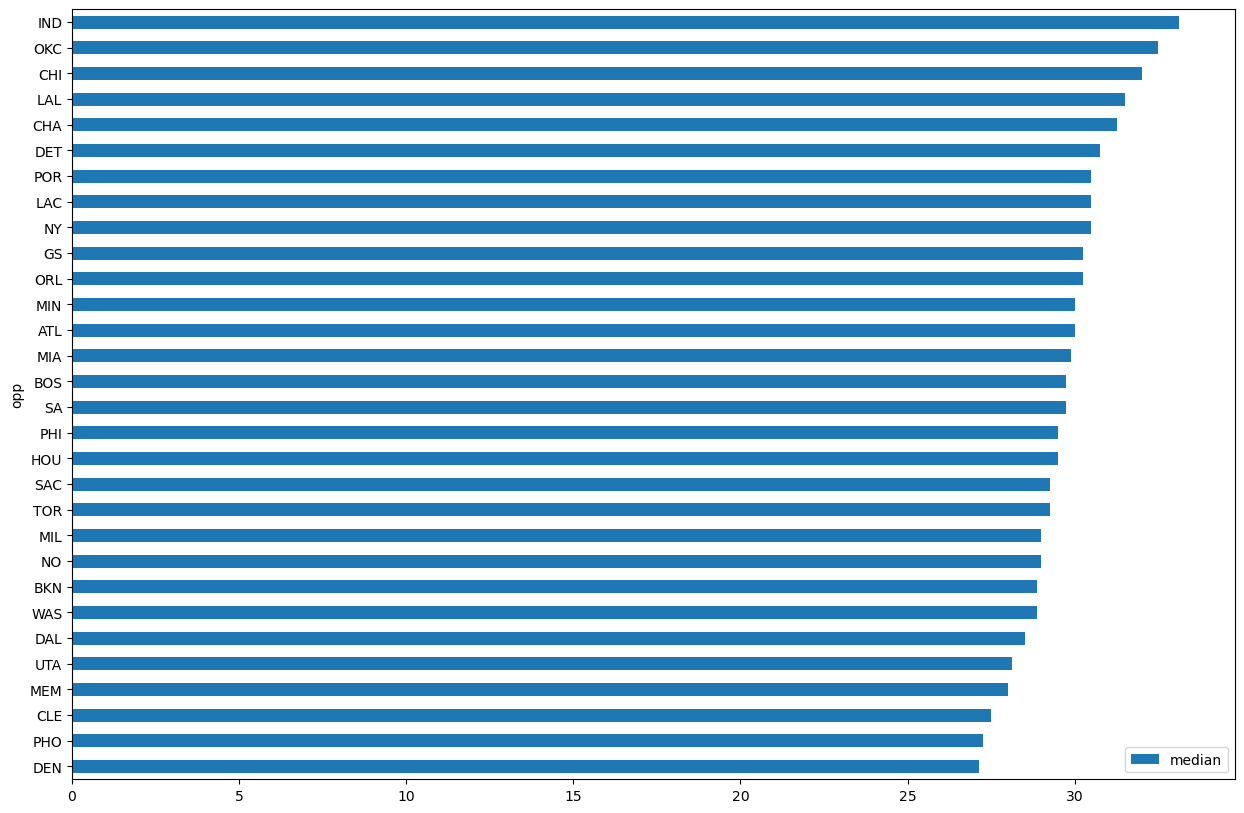

In [14]:
(df
 .loc[df['starter']==1]
 .groupby('opp')
 ['fpts']
 .agg(['median'])
 .sort_values('median')
 .plot
 .barh(
     figsize=(15,10),
 )
);

In [19]:
stats = ['fppm', 'fpts']
agg = ['median', 'count']
new_columns = [f'{stat}-{agg_}' for stat in stats for agg_ in agg ]
new_columns

['fppm-median', 'fppm-count', 'fpts-median', 'fpts-count']

In [25]:
(df
 .groupby('name')
 [stats]
 .agg(agg)
 .set_axis(new_columns, axis=1)
 .drop([col for col in new_columns if 'count' in col and col != new_columns[-1]], axis=1)
 .rename({new_columns[-1]: 'n-games'}, axis=1)
 .pipe(lambda df_: df_.loc[df_['n-games'] > 10])
)

,fppm-median,fpts-median,n-games
name,,,
AJ Green,0.6395,2.500,12
AJ Griffin,0.7745,17.625,28
Aaron Gordon,1.0560,30.250,27
Aaron Holiday,0.6320,10.500,28
Aaron Nesmith,0.7910,17.875,28
...,...,...,...
Yuta Watanabe,0.7560,17.000,19
Zach Collins,1.0120,23.000,19
Zach LaVine,1.0650,37.000,27
